In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import yfinance as yf

ticker = "ANTM.JK"

Ticker = yf.Ticker(ticker)
price_history = Ticker.history(period="max")
price_history.to_csv(f'{ticker}_price_history.csv')

In [3]:
import pandas as pd
price_history = pd.read_csv(f'{ticker}_price_history.csv')

In [4]:
def split_data(data, test_size=0.2):
  data_size = len(data)
  train_size = int(data_size * (1 - test_size))

  data_train = data[:train_size]
  data_test = data[train_size:]

  return data_train, data_test

In [5]:
import numpy as np

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [6]:
price_data_train, price_data_test = split_data(price_history, test_size=0.2)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_price_train = scaler.fit_transform(price_data_train['Close'].values.reshape(-1, 1))
scaled_price_test = scaler.fit_transform(price_data_test['Close'].values.reshape(-1, 1))

In [8]:
SEQUENCE_LENGTH = 30

X_train, y_train = create_sequences(scaled_price_train, seq_length=SEQUENCE_LENGTH)
X_test, y_test = create_sequences(scaled_price_test, seq_length=SEQUENCE_LENGTH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dense(1))

# opt = keras.optimizers.Adam(learning_rate=0.01)
# model.compile(optimizer=opt)

model.compile(optimizer='adam', loss='mse') # default lr = 10e-3

print(model.summary())

2024-05-07 12:08:14.380464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 12:08:14.380554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 12:08:14.431829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 12:08:14.548208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 12:08:15.865163: W tensorflow/compiler/tf2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 128)           33792     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 76065 (297.13 KB)
Trainable params: 76065 (297.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(filepath='model.weights.h5', monitor='loss', save_weights_only=True)
]

history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/20


2024-05-07 12:08:24.884723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/kevin/anaconda3/envs/tf/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2024-05-07 12:08:25.502834: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f66349efd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-07 12:08:25.502886: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-05-07 12:08:25.518083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715058505.625527    1548 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 [==============================] - 11s 37ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 2/20
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 3/20
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 4/20
114/114 [==============================] - 3s 27ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 5/20
114/114 [==============================] - 3s 27ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/20
114/114 [==============================] - 3s 27ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 7/20
114/114 [==============================] - 3s 28ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 8/20
114/114 [==============================] - 3s 26ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 9/20
114/114 [==============================] - 3s 26ms/step - loss: 9.9686e-04 - val_loss: 0.0013
Epoch 10/20
114/114 [==============================] - 3s 27ms/step - loss: 0.0010 - val_loss: 0.

In [11]:
# LSTM prediction

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE LSTM  : {mse}")
print(f"RMSE LSTM : {rmse}")
print(f"MAE LSTM  : {mae}")


28/28 [==============================] - 2s 16ms/step
MSE LSTM  : 0.001111668678178043
RMSE LSTM : 0.03334169579037699
MAE LSTM  : 0.022776707504257955


In [12]:
y_pred_rescaled = scaler.inverse_transform(y_pred)

In [13]:
train_size = len(price_data_train)
train_price_plot = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot['Prediction'] = y_pred_rescaled.flatten()

/tmp/ipykernel_1402/1873714381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot['Prediction'] = y_pred_rescaled.flatten()


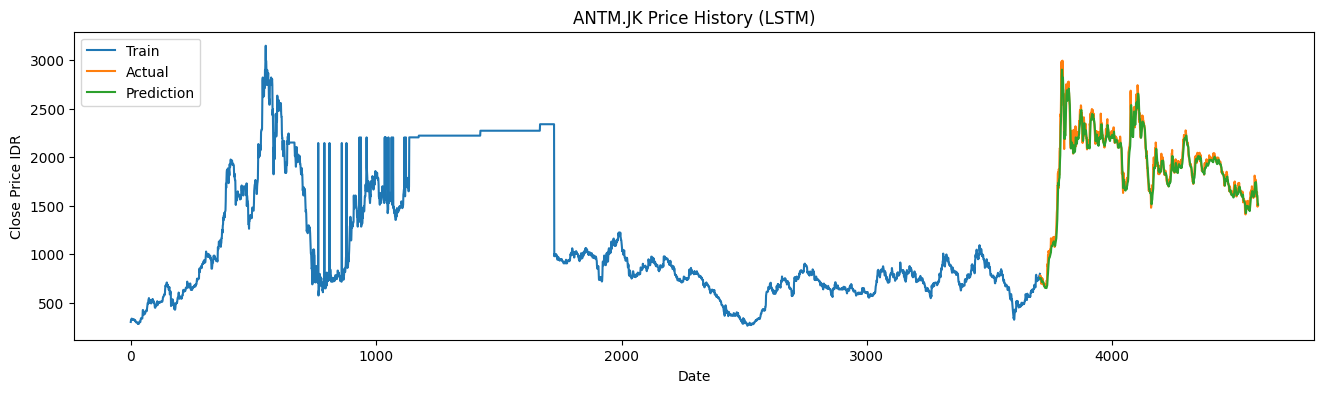

In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (LSTM)')
plt.plot(train_price_plot['Close'])
plt.plot(test_price_plot[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()

# RandomForestRegressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

X_train_2d = X_train.squeeze()
y_train_1d = y_train.squeeze()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_2d, y_train_1d)

RandomForestRegressor(random_state=42)

In [16]:
print([estimator.tree_.max_depth for estimator in rf.estimators_])

[24, 25, 26, 25, 24, 23, 25, 23, 26, 24, 26, 27, 25, 23, 23, 25, 25, 23, 27, 24, 23, 24, 26, 27, 25, 23, 25, 24, 25, 25, 25, 22, 27, 26, 24, 25, 24, 25, 24, 26, 25, 25, 28, 24, 26, 25, 23, 31, 27, 26, 26, 25, 23, 23, 29, 24, 24, 24, 24, 24, 27, 26, 23, 25, 25, 26, 29, 26, 24, 25, 24, 24, 23, 21, 28, 27, 25, 25, 29, 24, 26, 27, 23, 25, 24, 24, 25, 24, 24, 25, 25, 23, 25, 28, 23, 26, 24, 23, 23, 22]


In [17]:
X_test_2d = X_test.squeeze()

y_pred_rf = rf.predict(X_test_2d)
y_test_1d = y_test.squeeze()

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

print(f"MSE RF  : {mse}")
print(f"RMSE RF : {rmse}")
print(f"MAE RF  : {mae}")


MSE RF  : 0.0011099834222813908
RMSE RF : 0.03331641370678109
MAE RF  : 0.022518152138204857


In [18]:
y_pred_rescaled_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))

In [19]:
train_size = len(price_data_train)
train_price_plot_rf = price_history[:train_size + SEQUENCE_LENGTH]
test_price_plot_rf = price_history[train_size + SEQUENCE_LENGTH:]
test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()

/tmp/ipykernel_1402/11579854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_price_plot_rf['Prediction'] = y_pred_rescaled_rf.flatten()


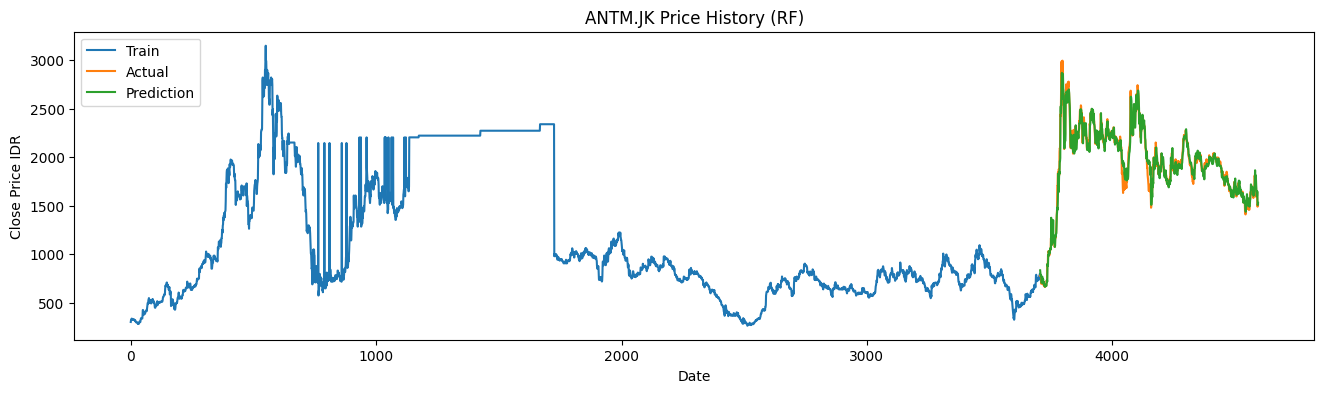

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 4))
plt.title(f'{ticker} Price History (RF)')
plt.plot(train_price_plot_rf['Close'])
plt.plot(test_price_plot_rf[['Close', 'Prediction']])
plt.xlabel('Date')
plt.ylabel(f'Close Price IDR')
plt.legend(['Train', 'Actual', 'Prediction'], loc='upper left')
plt.show()